In [1]:
import numpy as np
import torch
import scipy
import time

import sys
sys.path.insert(1, './PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt
from pinnutils import PINN
#from pinnutils import PINNN

In [2]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [3]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Quantum Harmonic Oscillator
$$
\biggr\{\begin{array}{rll}
       -\Delta u(x) + V(u(x))  &= \lambda u(x)  &,  \forall x\in\Omega  \\
         u(x)  -g(x)     &= 0   &,  \forall x\in\partial\Omega
\end{array}
$$
with, 
$$g(x_1,x_2) = \frac{\pi^{-1/4}}{ \sqrt{2^{n_1+n_2}n_1!n_2!}}e^{-\frac{(x_1^2+x_2^2)}{2}}H_{n_1}(x_1)H_{n_2}(x_2)$$

In [12]:
#Doamin 0ounds
#lb = np.array([-1, -1.0, 0.0])
#ub = np.array([1.0, 1.0, 0])
n_x = 4
n_y = 4
omega = n_x + n_y +1
#Create 2-D Dataset from the analytical solution
def Herm_pol(n):
    #p =  sp.Symbol('p')
    #Hn = sp.lambdify(p,sp.hermite(n, p))
    return scipy.special.hermite(n)
#lam = int(eigenvalue(e_l,e_l)(0,0))
def Psi (x,y,n_x, n_y):
    Hnx= Herm_pol(n_x)
    Hny= Herm_pol(n_y)
    #psi_t = torch.exp(torch.complex(torch.Tensor([0]),torch.Tensor([0])))
    return 1/((2**(n_x+n_y)*scipy.math.factorial(n_y)*scipy.math.factorial(n_x))**(1/2))*(np.pi**(-1/4))*np.exp(-(x**2+y**2)/2)*Hnx(x)*Hny(y)

In [13]:
rect = np.array([[-5.3, 5.3], [-5.3, 5.3]])
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=50, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=200, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=200, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])), dtype = torch.float32)

### Gradient Flow

In [14]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [15]:
# Sobolev Order
sob_2d.set_s(-1)
sob_1d_0.set_s(0)

In [16]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()
xs = torch.tensor(xs)
xs_bdx =  torch.tensor(xs_bndr_0[0])
X_t, Y_t = torch.meshgrid(xs[0],xs[1])
X_d = torch.tensor(X_t.reshape(-1), dtype = torch.float32)
Y_d = torch.tensor(Y_t.reshape(-1), dtype = torch.float32)
X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)

u_gt= torch.tensor(Psi(X_t.detach(),Y_t.detach(),n_x,n_y), dtype = torch.float32)
w_2d = torch.tensor(sob_2d.get_leja_weights(), dtype = torch.float32)
w_1d = torch.tensor(sob_1d_0.get_leja_weights(), dtype = torch.float32)

/tmp/ipykernel_160118/2716522220.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_d = torch.tensor(X_t.reshape(-1), dtype = torch.float32)
/tmp/ipykernel_160118/2716522220.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_d = torch.tensor(Y_t.reshape(-1), dtype = torch.float32)
/tmp/ipykernel_160118/2716522220.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
/tmp/ipykernel_160118/2716522220.py:13: UserWarnin

In [17]:
#Sobolev Metrics
metric_2d = sob_2d.metric()#(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
K_x = 1/2*(dx2+dy2)
V = 1/2*torch.diag((X_d**2 + Y_d**2))
eq = lambda u, mu: -matmul(K_x, u)+ matmul(V,u)- omega*u
crit_pde = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bdxl = lambda u: sob_1d_0.l2_loss(u-u_bdxl)
crit_bdxr = lambda u: sob_1d_0.l2_loss(u-u_bdxr)
crit_bdyl = lambda u: sob_1d_0.l2_loss(u-u_bdyl)
crit_bdyr = lambda u: sob_1d_0.l2_loss(u-u_bdyr)
#grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
#grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
#grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

In [19]:
TD = X_pde.detach().numpy()
# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True),device=device)
X_std = torch.tensor(np.std(TD, axis=0, keepdims=True),device=device)
seedc = 1

In [20]:
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)


In [21]:
def closure(optim):
        optim.zero_grad()
        loss.backward()
        return loss

In [22]:
class Beta(torch.nn.Module):

    def __init__(self, param_size =1):
        super(Beta, self).__init__()
        self.param_size = param_size
        self.fc_In = torch.nn.Linear(1,1, bias =  False)

    def set_weights(self, val):
        with torch.no_grad():
            self.fc_In.weight.copy_(val*torch.ones_like(self.fc_In.weight))

    def forward(self, x):
        out = self.fc_In.weight*torch.ones_like(x)
        return out
## Define the Surrogate for the ingering parameter


In [23]:
# Surrogate Model
lam_t = Beta()
lam_t(torch.tensor([0]))[0][0]

tensor(-0.9304, grad_fn=<SelectBackward0>)

In [24]:
lam_s = torch.max(torch.linalg.eig(dy2)[0].real)

In [ ]:
lam_t.set_weights(torch.tensor([1.0]))
net = PINN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
n_epochs   = 30000
lamb  = 1
losses_bc  = [];
losses_reg = [];
params = [{'params': net.parameters()}]
milestones = [[15000,25000]]
optimizer = torch.optim.Adam(params)
optim_lam_t =  torch.optim.Adam(lam_t.parameters())
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
start_time = time.time()
ds = 1
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    optim_lam_t.zero_grad()
    
    lam_p = lam_t(torch.tensor([0]))[0][0]
    uhat  = net(X_pde).T[0]
    #l_pde   = crit_pde(uhat)
    l_pde = torch.sum((eq(uhat,lam_p)*w_2d)**2)
    
    l_rec = torch.sum(((uhat-u_gt.reshape(-1))*w_2d)**2)
    
    
    loss = l_pde/lam_s + l_rec
    losses_reg.append(l_pde.item())
    
    loss.backward()
    optimizer.step()
    optim_lam_t.step()
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 7851


In [27]:
X_test, Y_test = torch.meshgrid(torch.linspace(-5.3,5.3,100),torch.linspace(-5.3,5.3,100))
X_T = torch.cat((X_test.reshape(-1,1), Y_test.reshape(-1,1)),1) 

pred rel. linf-error = 8.222764e-03
pred rel. l2-error = 8.759195e-04
pred_rel_std. linf-error = 8.293117e-04


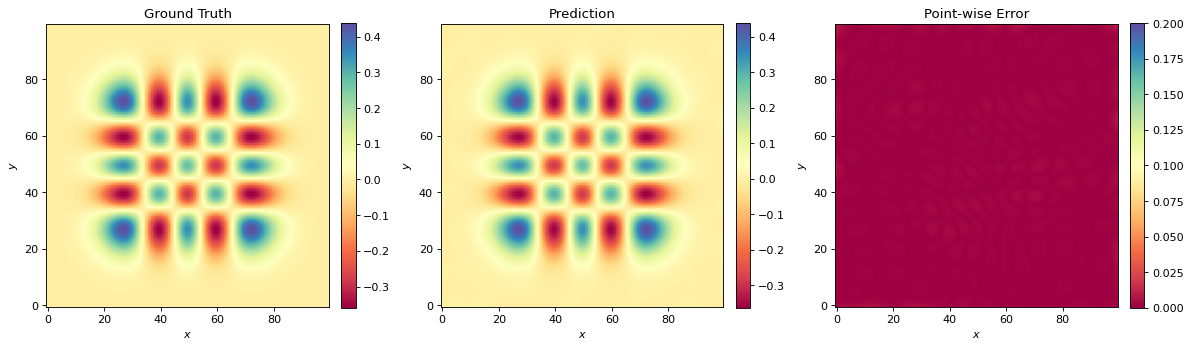

In [28]:
plt.figure(figsize=(15, 25), dpi=80)
u_sol = Psi(X_test,Y_test,n_x,n_y).detach().numpy()
out = net(X_T).reshape(100,100).detach().numpy()
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
print("pred_rel_std. linf-error = {:e}".format(np.std(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
#plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
#plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.clim(0,0.2)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.gcf().set_size_inches(14,4)
plt.tight_layout()
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')